In [1]:
import sri_tabi_problem as sri  # TODO rename to sirlo

import pyro
import torch
import pyro.distributions as dist
from chirho.dynamical.ops import State
from collections import OrderedDict
from typing import (
    Union,
)
import matplotlib.pyplot as plt

import chirho.contrib.compexp as ep  # TODO rename to expectation_programming (?)

pyro.settings.set(module_local_params=True)

PT = torch.nn.Parameter
TT = torch.Tensor
tt = torch.tensor
UPTT = Union[PT, TT]

assert sri.LOCKDOWN_TYPE == sri.LockdownType.NONCONT_STATE

# Set true just to see if everything runs (a smoke test). Set false to run everything for full count of iterations.
SMOKE = True

In [2]:
# Define some default values for parameters.

# Decision (lockdown) parameters.
# Decision (lockdown) parameters.
DEFAULT_FLAT_DPARAMS = DFDP = tt([0.1, 0.25, 0.8])

def get_keyed_dparams(flat_dparams):
    # This hack is required because the expectation_programming library expects a flat vector of
    #  decision parameters, but the sir model expects them to be keyed out. Reversing this process,
    #  where we would build a flat vector from these values, does not work due to pytorch failing
    #  to propagate gradients through any form of concatenating these parameters together.
    # See here: https://github.com/pytorch/xla/issues/870
    return OrderedDict(
        # When the infected proportion of the population exceeds this value, a lockdown is triggered.
        lockdown_trigger=flat_dparams.select(0, 0),
        # When the recovered proportion of the population exceeds this value, the lockdown is lifted.
        lockdown_lift_trigger=flat_dparams.select(0, 1),
        # The strength of the lockdown.
        lockdown_strength=flat_dparams.select(0, 2)
    )

# Latent paremeters.
DEFAULT_STOCHASTICS = DST = OrderedDict(
    # The infection transmission rate.
    beta=tt(13.0),
    # The infection recovery rate.
    gamma=tt(2.0),
    # The capacity of the healthcare system as a proportion of the population.
    capacity=tt(0.01),
    # The rate at which infected individuals require hospitalization.
    hospitalization_rate=tt(0.05)
)

# Initial conditions.
DEFAULT_INIT_STATE = DIS = State(
    # Proportion of the population susceptible to a disease.
    S=tt(0.99),
    # Proportion of the population infected with a disease.
    I=tt(0.01),
    # Proportion of the population recovered from a disease.
    R=tt(0.0),
    # Strength of active lockdown.
    l=tt(0.0),
    # Integral over strength of past lockdowns. This is a proxy measure of the social and economic
    # costs incurred from a lockdown.
    L=tt(0.0),
    # Integral of the number of individuals requiring hospitalization that could not receive it.
    O=tt(0.0)
)

# Timespan of interest.
DEFAULT_TIMES = DT = torch.linspace(0., 5., 100)

# Utility function allowing copies that ensure default parameters are unaffected.
def copy_odict(odict: OrderedDict[str, TT]) -> OrderedDict[str, TT]:
    return OrderedDict((k, tt(v.item())) for k, v in odict.items())

def copy_flat_dparams(flat_dparams: PT) -> PT:
    return PT(tt(flat_dparams.detach().numpy()))

In [3]:
# A prior defined only for parameters affecting healthcare capacity overruns.
HOSPITALIZATION_RATE_SCALE = 0.015
CAPACITY_SCALE = 0.003
def _pyro_prior_over_healthcare_params():
    capacity = pyro.sample(
        "capacity", dist.Normal(DST['capacity'], CAPACITY_SCALE))
    hospitalization_rate = pyro.sample(
        "hospitalization_rate", dist.Normal(DST['hospitalization_rate'], HOSPITALIZATION_RATE_SCALE))
    return OrderedDict(
        capacity=capacity,
        hospitalization_rate=hospitalization_rate
    )

# A prior defined only for parameters affecting the vanilla SIR model.
BETA_SCALE = 1.0
GAMMA_SCALE = 0.2
def pyro_prior_sir():
    beta = pyro.sample(
        "beta", dist.Normal(DST['beta'], BETA_SCALE))
    gamma = pyro.sample(
        "gamma", dist.Normal(DST['gamma'], GAMMA_SCALE))
    return OrderedDict(
        beta=beta,
        gamma=gamma
    )

# A prior over all four stochastic variables.
def pyro_prior_full():
    healthcare_params = _pyro_prior_over_healthcare_params()
    sir_params = pyro_prior_sir()
    return OrderedDict(**healthcare_params, **sir_params)

## Modeling Lockdowns and Burden on Healthcare System

In the **top panel**, we see the trajectory of a standard SIR model affected by a lockdown. The infected proportion rises until the lockdown is triggered, at which time the curve flattens. In this case, this severe lockdown is lifted prematurely, and the infected curve rises to a proportion resulting in a healthcare criss.
The **middle panel** zooms in on this curve and shows the aggregate overrun of the healthcare system.
The **bottom panel** shows the strength of the lockdown over time and the aggregate cost of that lockdown.

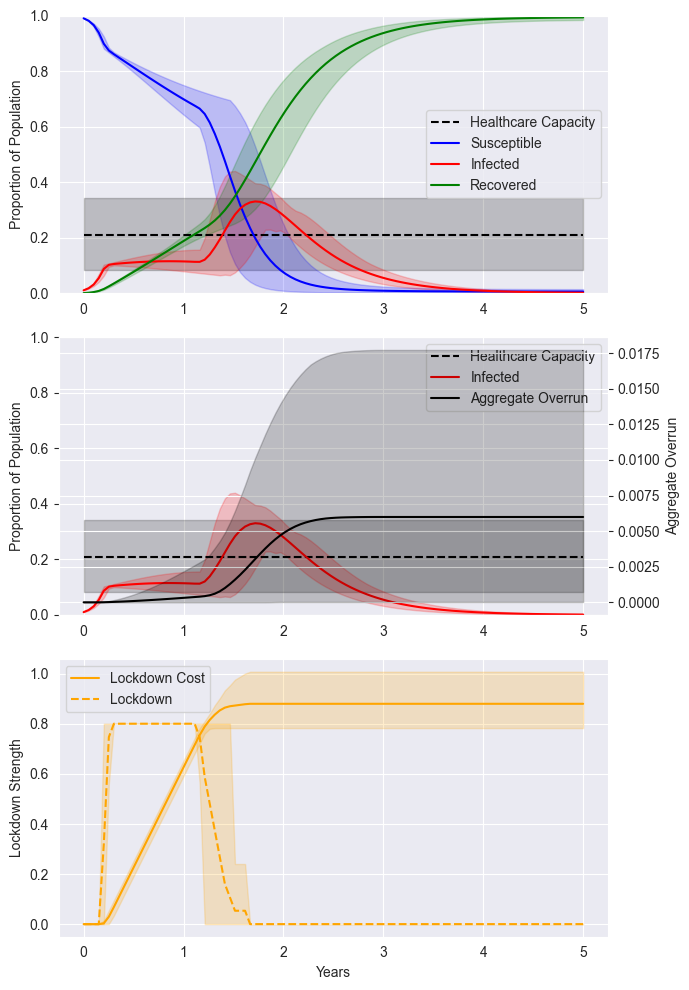

In [4]:
sri.plot_basic(
    dparams=get_keyed_dparams(DFDP),
    stochastics=[pyro_prior_full() for _ in range(200 if not SMOKE else 15)],
    init_state=DIS,
    timespan=DT,
    ci=0.9
)

## Minimizing Lockdown Severity while Avoiding Healthcare System Burden

Overburdening the healthcare system is clearly something to avoid, but lockdowns induce steep social and economic costs. Can policymakers avoid overburdening the hospital system while minimizing the length and severity of the lockdown? As a first step, we define functionals that measure the expected costs with respect to the uncertainty induced by a distribution over the stochastic parameters.

In [5]:
def get_costs(dparams: ep.typedecs.KWTypeNNParams):

    def lockdown_cost_(stochastics: ep.typedecs.KWType) -> torch.Tensor:
        traj = sri.get_traj(dparams, stochastics, timespan=DT, init_state=DIS)
        # Return the aggregate cost of the lockdown at the end of the simulation.
        return traj.L[-1]

    def healthcare_burden_(stochastics: ep.typedecs.KWType) -> torch.Tensor:
        traj = sri.get_traj(dparams, stochastics, timespan=DT, init_state=DIS)
        # Return the aggregate burden on the healthcare system at the end of the simulation.
        return traj.O[-1]

    return lockdown_cost_, healthcare_burden_

In [6]:
# Cost functions of interest.
optimizeable_flat_decision_parameters = copy_flat_dparams(DFDP)
lockdown_cost, healthcare_burden = get_costs(get_keyed_dparams(optimizeable_flat_decision_parameters))

# Functionals of these costs, defined as expectations from the `expectation_programming` package.
expected_lockdown_cost = ep.E(f=lockdown_cost, name='elc')
expected_healthcare_burden = ep.E(f=healthcare_burden, name='ehb')

### Combined Cost
As a first step, we'll combine these into a single cost function. The `expectation_programming` package allows us to use standard python syntax to do so, except that constant factors must be wrapped in `ep.Constant` objects. The scaling here is simply to put the two costs on compareable scales.

In [7]:
expected_combined_cost = ep.Constant(tt(2e2)) * expected_healthcare_burden + expected_lockdown_cost

### Estimating Expectations
To estimate an expectation, we must employ one of the expectation handlers provided in the `expectation_programming` package. These handlers define how an expectation will be estimated. For example, the monte carlo handler below simply samples from `pyro_prior_full`, pushes those samples through the cost functions, and then averages the results.

In [8]:
with ep.MonteCarloExpectationHandler(num_samples=50 if not SMOKE else 3):
    print("Expected Combined Cost:", expected_combined_cost(pyro_prior_full))

Expected Combined Cost: tensor(1.6160, grad_fn=<AddBackward0>)


### Optimizing Lockdown Policy with SGD
We can also take gradients of these expectations, and then utilize those gradient estimates in an SGD algorithm to optimize the lockdown parameters. The `ep.ComposedExpectation` cost is passed to a `DecisionOptimizer`, which then calls `ep.ComposedExpectation.grad` to get a new `ep.ComposedExpectation` defining the expected gradient of the original cost function with respect to the decision parameters. This gradient then features in components of the optimization loop, and is estimated just like any other `ep.ComposedExpectation`.

In [9]:
class DecisionOptimizer:
    def __init__(
            self,
            flat_dparams: PT,
            model: ep.typedecs.ModelType,
            cost: ep.ComposedExpectation,
            expectation_handler: ep.ExpectationHandler,
            lr: float
    ):
        self.flat_dparams = flat_dparams
        self.model = model
        # ep.ComposedExpectation objects can be auto-differentiated.
        self.cost_grad = cost.grad(self.flat_dparams)
        self.expectation_handler = expectation_handler
        self._lr = lr

        self.optim = torch.optim.SGD((self.flat_dparams,), lr=self._lr)

    @property
    def lr(self):
        return self._lr

    @lr.setter
    def lr(self, lr):
        self._lr = lr
        for g in self.optim.param_groups:
            g['lr'] = lr

    def estimate_grad(self):
        self.optim.zero_grad()
        self.flat_dparams.grad = None

        with self.expectation_handler:
            grad_estimate_: TT = self.cost_grad(self.model)

        return grad_estimate_

    def step_grad(self, grad_estimate_):
        self.flat_dparams.grad = grad_estimate_
        self.optim.step()

    def step(self):
        grad_estimate = self.estimate_grad()
        self.step_grad(grad_estimate)

In [10]:
combined_do = DecisionOptimizer(
    flat_dparams=optimizeable_flat_decision_parameters,
    model=pyro_prior_full,
    cost=expected_combined_cost,
    # For SGD, we just use a single sample per update.
    expectation_handler=ep.MonteCarloExpectationHandler(num_samples=1),
    lr=2e-3
)

lockdown_lift_combined_vals = []
lockdown_trigger_combined_vals = []
lockdown_strength_combined_vals = []

In [21]:
def norm_to_clip(grad_estimate_, clip):
    mag = torch.norm(grad_estimate_)
    return torch.where(mag > clip, (grad_estimate_ / mag) * clip, grad_estimate_)

In [30]:
N = 300 if not SMOKE else 100
for i in range(N):
    grad_estimate = combined_do.estimate_grad()
    combined_do.step_grad(norm_to_clip(grad_estimate, tt(3.)))

    keyed_dparams = get_keyed_dparams(optimizeable_flat_decision_parameters)

    lockdown_lift_combined_vals.append(keyed_dparams['lockdown_lift_trigger'].item())
    lockdown_trigger_combined_vals.append(keyed_dparams['lockdown_trigger'].item())
    lockdown_strength_combined_vals.append(keyed_dparams['lockdown_strength'].item())

    print(f'Iteration {i+1} of {N}', end='\r')

In [14]:
def plot_lockdown_parameter_optimization(trigger_vals, lift_vals, strength_vals):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    fig.suptitle('Lockdown Policy Optimization')

    axs[0].plot(trigger_vals)
    axs[0].set_title('Lockdown Trigger')

    axs[1].plot(lift_vals)
    axs[1].set_title('Lockdown Lift Trigger')

    axs[2].plot(strength_vals)
    axs[2].set_title('Lockdown Strength')

    plt.show()

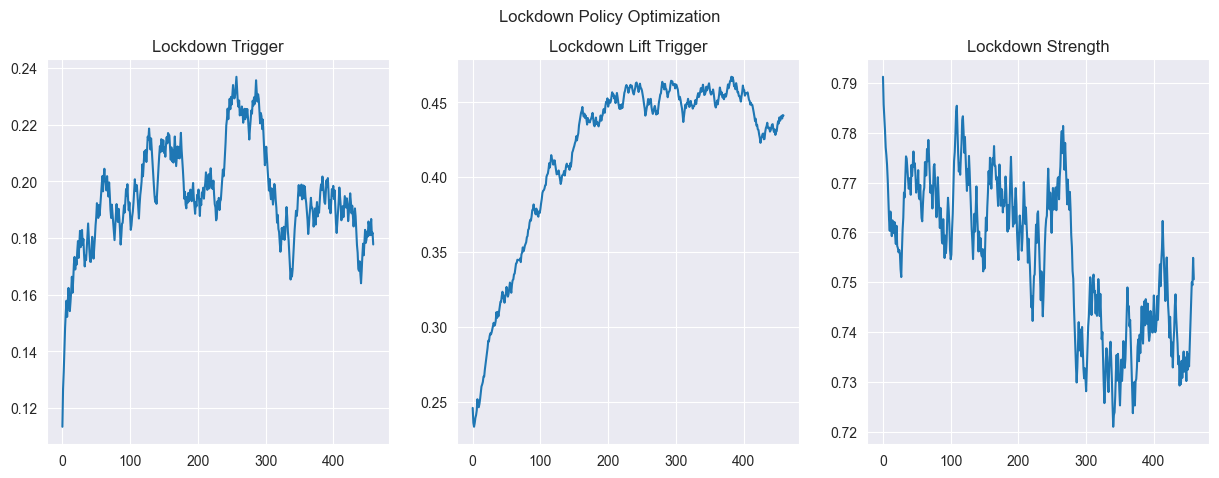

In [31]:
plot_lockdown_parameter_optimization(
    lockdown_trigger_combined_vals,
    lockdown_lift_combined_vals,
    lockdown_strength_combined_vals
)

### Optimized Lockdown Policy

After the optimization procedure, we see that the infected count repeatedly bounces off the average healthcare capacity, but doesn't grossly exceed it. In general, this is what we want to see: a policy that keeps the healthcare system from being overwhelmed, but also doesn't impose overly severe or premature lockdowns.

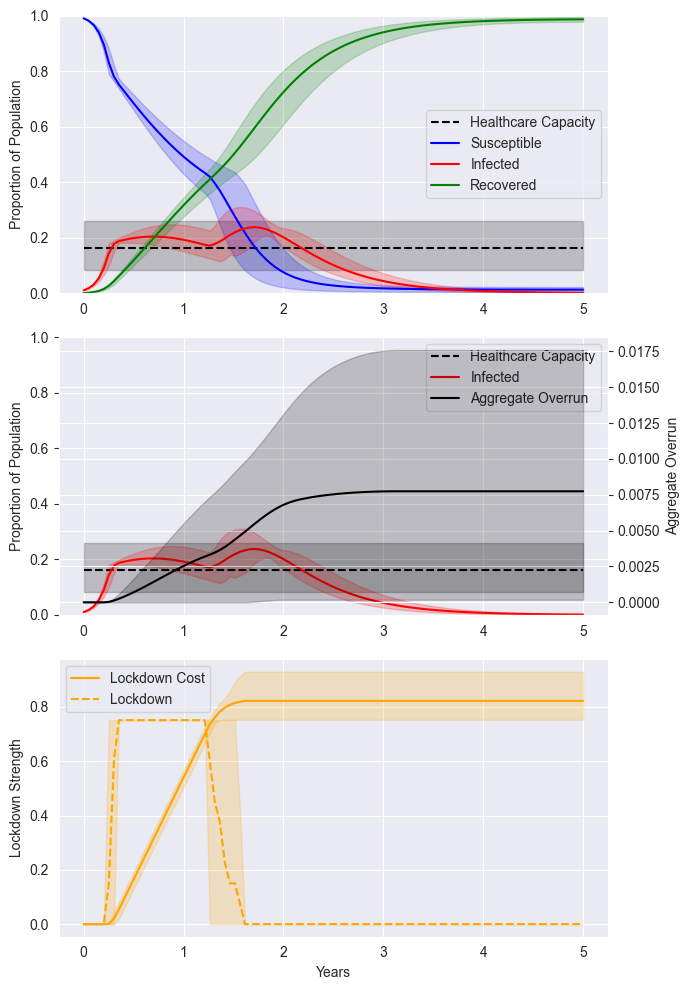

In [32]:
sri.plot_basic(
    dparams=get_keyed_dparams(optimizeable_flat_decision_parameters),
    stochastics=[pyro_prior_full() for _ in range(200 if not SMOKE else 10)],
    init_state=DIS,
    timespan=DT,
    ci=0.9
)

## Risk Constrained Optimization

Risk constraints offer a well-defined approach to combining these sorts of cost functions. Here, for example, we want to minimize the cost of the lockdown while ensuring we do not overwhelm the healthcare system. Risk constraints can help define this goal more explicitly by specifying that we want to minimize the cost while ensuring that, for example, the probability of exceeding a particular healthcare burden is less than some threshold.
We'll slowly build up to more complex constraints by starting with a simple constraint on the expected healthcare burden.

TODO cite the constrained-SGD papers and discuss how a constrained problem can be converted into an unconstrained problem.

#### Mean-Constraint

TODO Formally define the mean-constrained problem.

In [41]:
# We can represent the risk-mean-constrained optimization as follows, where the risk quantity "activates" only
#  when it exceeds the risk mean threshold.

# tau being "sufficiently large" is the key condition whereby the constrained problem can be reformulated into an unconstrained problem.
tau__meanc = ep.C(tt(1e3))

# Note that this is about half the expected burden after the joint optimization.
risk_mean_thresh = ep.C(tt(0.001))

# Again, we define the objective as a composition of expectations in standard python syntax. We'll re-use the parameters from the joint
#  optimization, however, as this can be interpreted as a fine-tuning on the lockdown policy found above.
risk_mean_constrained_obj = expected_lockdown_cost + tau__meanc * (expected_healthcare_burden - risk_mean_thresh).relu()

In [42]:
mean_constrained_do = DecisionOptimizer(
    flat_dparams=optimizeable_flat_decision_parameters,
    model=pyro_prior_full,
    cost=risk_mean_constrained_obj,
    # For SGD, we just use a single sample per update.
    expectation_handler=ep.MonteCarloExpectationHandler(num_samples=1),
    lr=combined_do.lr / 5.  # Reduced learning rate for fine tuning.
)

In [43]:
lockdown_lift_meanc_vals = []
lockdown_trigger_meanc_vals = []
lockdown_strength_meanc_vals = []

In [59]:
N = 250 if not SMOKE else 300
for i in range(N):
    grad_estimate = mean_constrained_do.estimate_grad()
    mean_constrained_do.step_grad(norm_to_clip(grad_estimate, tt(3.)))

    keyed_dparams = get_keyed_dparams(optimizeable_flat_decision_parameters)

    lockdown_lift_meanc_vals.append(keyed_dparams['lockdown_lift_trigger'].item())
    lockdown_trigger_meanc_vals.append(keyed_dparams['lockdown_trigger'].item())
    lockdown_strength_meanc_vals.append(keyed_dparams['lockdown_strength'].item())

    print(f'Iteration {i+1} of {N}', end='\r')

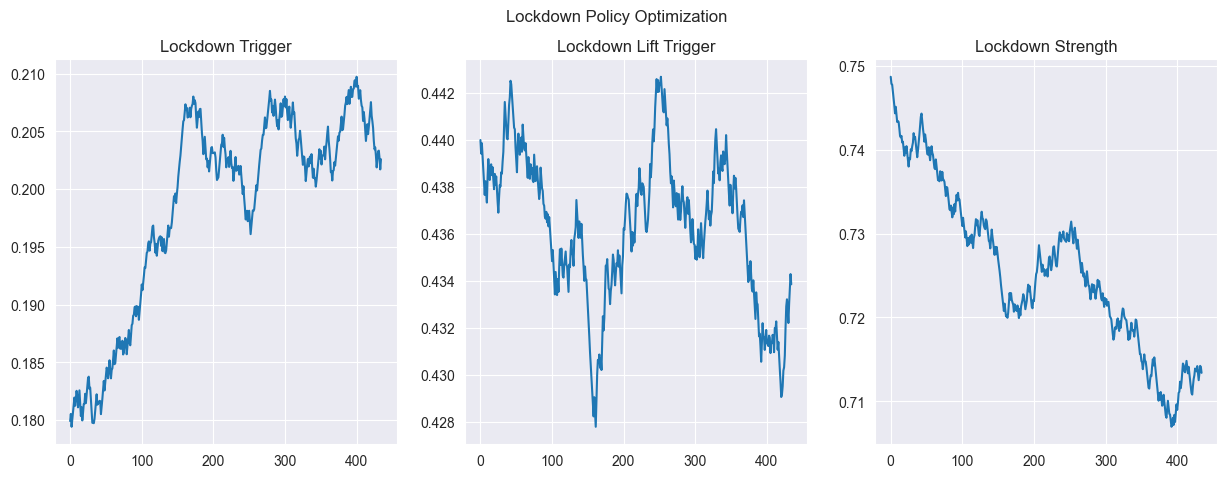

In [62]:
plot_lockdown_parameter_optimization(
    lockdown_trigger_meanc_vals,
    lockdown_lift_meanc_vals,
    lockdown_strength_meanc_vals
)

##### Optimized Lockdown Policy (Mean-Constrained)

Below, we see that the expected healthcare burden is now kept at the prescribed threshold of `0.001`. TODO it's not, maybe some LR scheduling OR maybe it's time for TABI even before we get to CVaR? Also run longer so the thing actually converges...

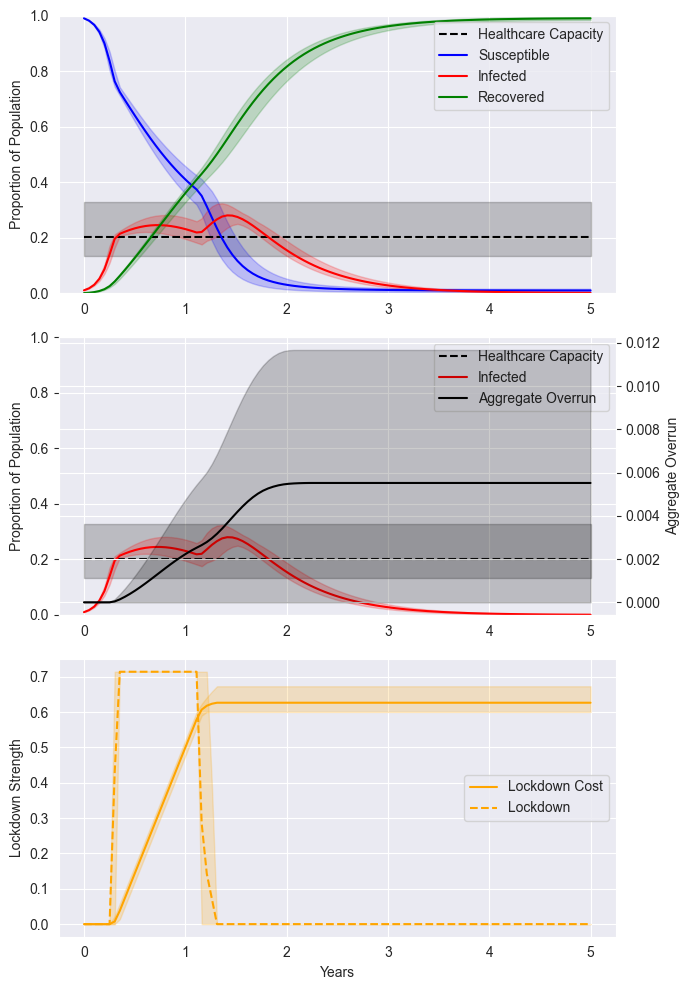

In [63]:
sri.plot_basic(
    dparams=get_keyed_dparams(optimizeable_flat_decision_parameters),
    stochastics=[pyro_prior_full() for _ in range(200 if not SMOKE else 10)],
    init_state=DIS,
    timespan=DT,
    ci=0.9
)